In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

import joblib 
import re
import string
import unicodedata
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [2]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # print(textes)
        text = str(text)
        text = text.lower()
        normalized = unicodedata.normalize("NFD", text)
        text = "".join(c for c in normalized if unicodedata.category(c) != "Mn")
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        return text

In [3]:
# Swap between these
# pipeline_lr.joblib
# pipeline_mlp.joblib
# pipeline_rf.joblib
# pipeline_xgb.joblib

stack = joblib.load('../../Models/80-20 Test/pipeline_rf.joblib')

training = pd.read_csv('../../Data Splits/test_data.csv')

training_x = training['article']

training_y = training['label']

x = stack.named_steps['vectorizer'].transform(training_x)
print(x.shape)



(321, 34125)


Metrics for MNB:
Accuracy: 0.838006230529595
Precision: 0.7621359223300971
Recall: 0.98125
F1 Score: 0.8579234972677595
AUC: 0.9784549689440993
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81       161
           1       0.76      0.98      0.86       160

    accuracy                           0.84       321
   macro avg       0.87      0.84      0.83       321
weighted avg       0.87      0.84      0.83       321



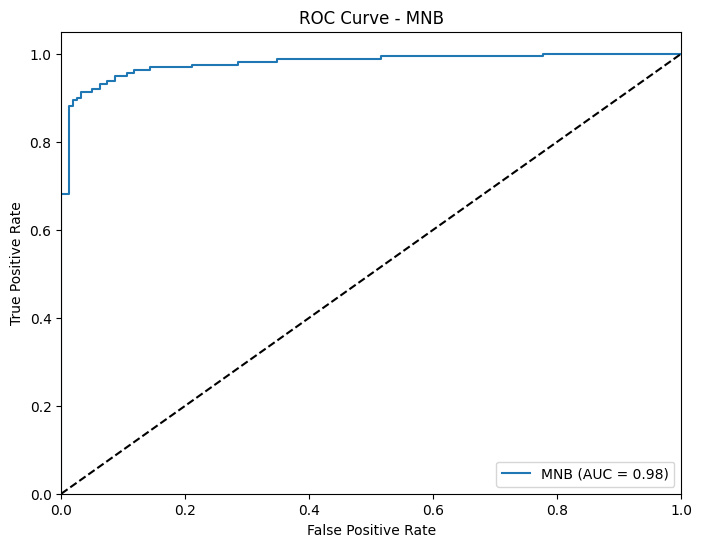

Metrics for LR:
Accuracy: 0.9314641744548287
Precision: 0.96
Recall: 0.9
F1 Score: 0.9290322580645162
AUC: 0.9857531055900621
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       161
           1       0.96      0.90      0.93       160

    accuracy                           0.93       321
   macro avg       0.93      0.93      0.93       321
weighted avg       0.93      0.93      0.93       321



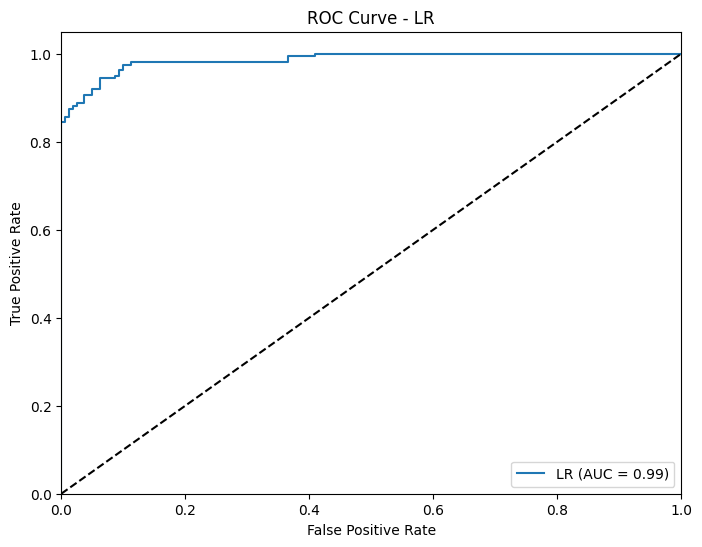

Metrics for RF:
Accuracy: 0.9127725856697819
Precision: 0.9177215189873418
Recall: 0.90625
F1 Score: 0.9119496855345912
AUC: 0.977930900621118
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       161
           1       0.92      0.91      0.91       160

    accuracy                           0.91       321
   macro avg       0.91      0.91      0.91       321
weighted avg       0.91      0.91      0.91       321



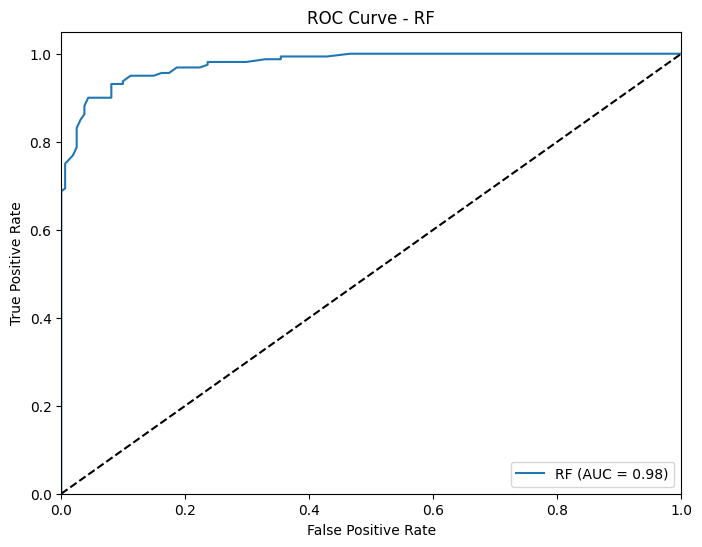

Metrics for KNN:
Accuracy: 0.8847352024922118
Precision: 0.8360655737704918
Recall: 0.95625
F1 Score: 0.892128279883382
AUC: 0.962111801242236
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       161
           1       0.84      0.96      0.89       160

    accuracy                           0.88       321
   macro avg       0.89      0.88      0.88       321
weighted avg       0.89      0.88      0.88       321



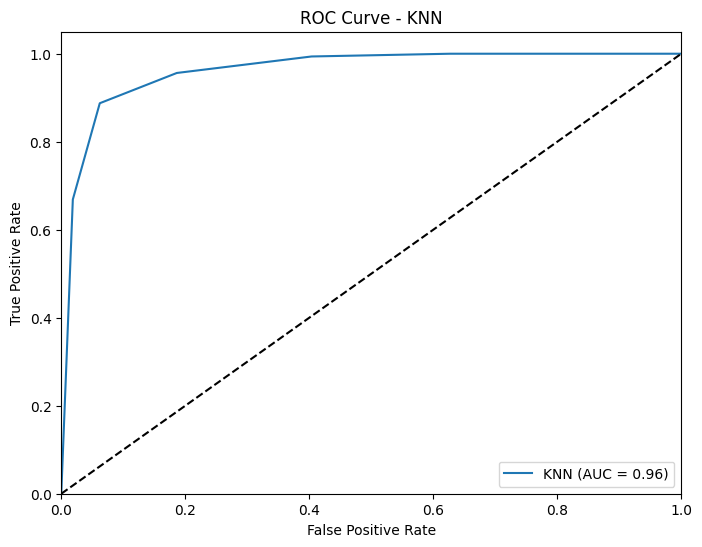

Metrics for SVM:
Accuracy: 0.9501557632398754
Precision: 0.9864864864864865
Recall: 0.9125
F1 Score: 0.948051948051948
AUC: 0.9889363354037267
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       161
           1       0.99      0.91      0.95       160

    accuracy                           0.95       321
   macro avg       0.95      0.95      0.95       321
weighted avg       0.95      0.95      0.95       321



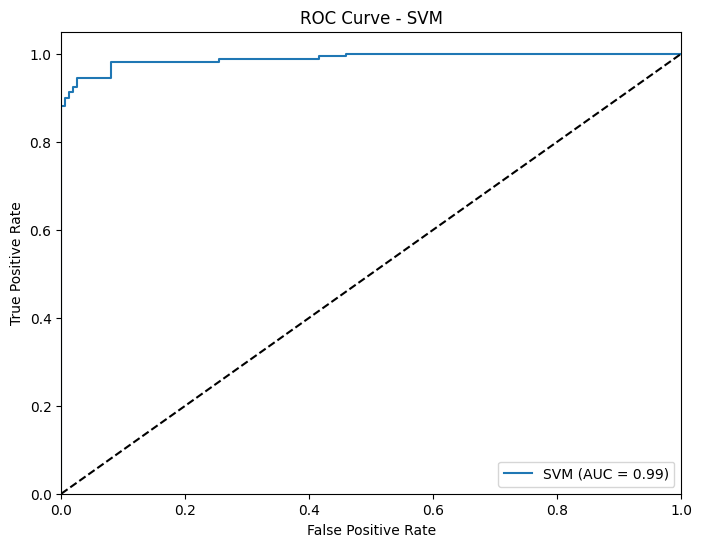

Metrics for Stacking Model:
Accuracy: 0.956386292834891
Precision: 0.967948717948718
Recall: 0.94375
F1 Score: 0.9556962025316456
AUC: 0.9938664596273292
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       161
           1       0.97      0.94      0.96       160

    accuracy                           0.96       321
   macro avg       0.96      0.96      0.96       321
weighted avg       0.96      0.96      0.96       321



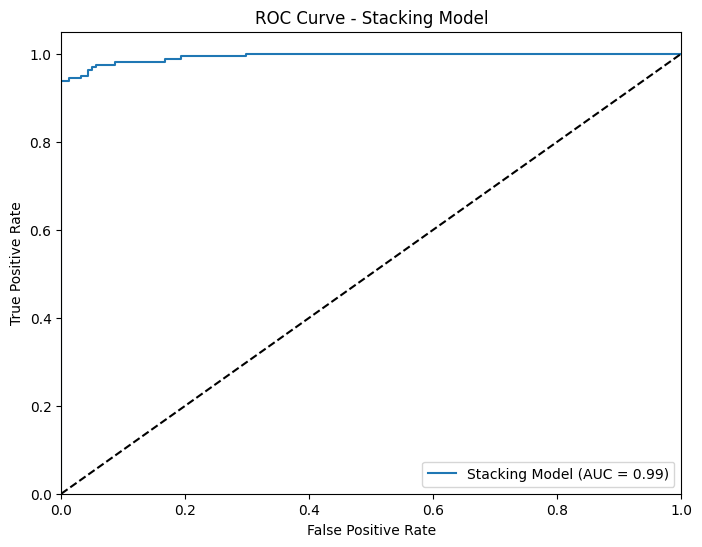

Comparison of Models:
                Accuracy Precision   Recall  F1 Score       AUC
MNB             0.838006  0.762136  0.98125  0.857923  0.978455
LR              0.931464      0.96      0.9  0.929032  0.985753
RF              0.912773  0.917722  0.90625   0.91195  0.977931
KNN             0.884735  0.836066  0.95625  0.892128  0.962112
SVM             0.950156  0.986486   0.9125  0.948052  0.988936
Stacking Model  0.956386  0.967949  0.94375  0.955696  0.993866


In [4]:
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

vectorized_text = stack.named_steps['vectorizer'].transform(training_x)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(training_y, y_pred)
    precision = precision_score(training_y, y_pred)
    recall = recall_score(training_y, y_pred)
    f1 = f1_score(training_y, y_pred)
    auc = roc_auc_score(training_y, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(training_y, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(training_y, y_prob)
    roc_auc = roc_auc_score(training_y, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()


# Evaluate stacking model
stack_y_pred = stack.predict(training_x)
stack_y_prob = stack.predict_proba(training_x)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(training_y, stack_y_pred)
stack_precision = precision_score(training_y, stack_y_pred)
stack_recall = recall_score(training_y, stack_y_pred)
stack_f1 = f1_score(training_y, stack_y_pred)
stack_auc = roc_auc_score(training_y, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(training_y, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(training_y, stack_y_prob)
stack_roc_auc = roc_auc_score(training_y, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)